In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [2]:
env = gym.make("MountainCar-v0")
env.reset()

# done = False

array([-0.51228494,  0.        ])

In [3]:
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space.n)

# make entire range from 0.6 to -1.2 to be seperated into 20 discrete value
DISCRETE_OS_SIZE = [20] * len(env.observation_space.high)
discrete_os_win_size = (env.observation_space.high - env.observation_space.low)/DISCRETE_OS_SIZE

print(discrete_os_win_size)

[0.6  0.07]
[-1.2  -0.07]
3
[0.09  0.007]


In [4]:
def get_discrete_state(state):
    discrete_state = (state - env.observation_space.low) / discrete_os_win_size
    return tuple(discrete_state.astype(np.int))

#only initialize the first 
discrete_state = get_discrete_state(env.reset())

print(discrete_state)

(8, 10)


In [5]:
#initialize array with random number between -2 to 0 with size of 20 x 20 x 3
q_table = np.random.uniform(low=-2, high=0, size=(DISCRETE_OS_SIZE + [env.action_space.n]))

# check the dimension size of table
print(q_table.shape)

print(q_table[discrete_state])

# simply check for max q value from table
# it will return 0 to 2 indicate as action 0, 1 or 2
print(np.argmax(q_table[discrete_state]))

(20, 20, 3)
[-1.74155139 -0.43682053 -0.17652743]
2


Episode:     0, average reward: -2.0, current epsilon: 0.50
Episode:   100, average reward: -200.0, current epsilon: 0.30
Episode:   200, average reward: -200.0, current epsilon: 0.10
Episode:   300, average reward: -200.0, current epsilon: -0.00
It completed on episode 355
Episode:   400, average reward: -199.7, current epsilon: -0.00


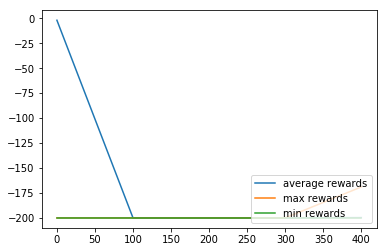

In [6]:
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 500
epsilon = 0.5
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES // 2
STATS_EVERY = 100

epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)
# For stats
ep_rewards = []
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}

for episode in range(EPISODES):
    episode_reward = 0
    discrete_state = get_discrete_state(env.reset())
    done = False
    while not done:
        action = np.argmax(q_table[discrete_state])
        new_state, reward, done, _ = env.step(action)
        episode_reward += reward
        new_discrete_state = get_discrete_state(new_state)
        #print(new_state)
        env.render()
        if not done:
            max_future_q = np.max(q_table[new_discrete_state])
            # The trailing comma for tuples, lists, or function arguments is good style especially
            # when have a long initialisation that is split over multiple lines
            # In the case of a single element tuple, the trailing comma is required
            # below line will return only the q value
            current_q = q_table[discrete_state + (action, )]

            new_q = (1 - LEARNING_RATE) *current_q + LEARNING_RATE * (reward + DISCOUNT * max_future_q)
            q_table[discrete_state + (action, )] = new_q
        elif new_state[0] >= env.goal_position:
            q_table[discrete_state + (action, )] = 0
            print("It completed on episode {}".format(episode))

        discrete_state = new_discrete_state
    
    if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
        epsilon -= epsilon_decay_value
    
    ep_rewards.append(episode_reward)
    
    if episode % 100 == 0:
        np.save(f"qtables/{episode}-qtable.npy", q_table)
        
    if not episode % STATS_EVERY:
            average_reward = sum(ep_rewards[-STATS_EVERY:])/STATS_EVERY
            aggr_ep_rewards['ep'].append(episode)
            aggr_ep_rewards['avg'].append(average_reward)
            aggr_ep_rewards['max'].append(max(ep_rewards[-STATS_EVERY:]))
            aggr_ep_rewards['min'].append(min(ep_rewards[-STATS_EVERY:]))
            
            print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {epsilon:>1.2f}')

            
env.close()

plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()